## Compliance Radar Machine Learning Project

### Project Overview

This project analyzes org_compliance_data.db — an organizational dataset containing department-level operational metrics, reporting frequency, financial indicators, audit results, and anonymized engagement scores — to detect signals of potential non-compliance and provide evidence-based recommendations for risk mitigation. The work emphasizes both predictive modeling and interpretable, ethically grounded insights so that findings can inform operational policy and governance.

##### Necessary Imports

In [38]:
# Neccessary imports to load the database and for data manipulation
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import os


#### Folder Paths

In [3]:
processed_data_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\data\\processed\\'
raw_data_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\data\\raw\\'
images_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\images\\'
reports_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\reports\\'

### Loading Data from the Database

In [4]:
# Creating a cursor to connect to the SQLite database
conn = sqlite3.connect('C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\data\\raw\\org_compliance_data.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)



Tables in the database: [('departments',), ('risk_summary_by_division',), ('high_risk_departments',), ('data_dictionary',)]


### Saving DB tables as CSV files for backup

In [5]:
# Reading each of the tables into pandas dataframes
departments_df = pd.read_sql_query("SELECT * FROM departments", conn)
risk_by_division_df = pd.read_sql_query("SELECT * FROM risk_summary_by_division", conn)
high_risk_departments_df = pd.read_sql_query("SELECT * FROM high_risk_departments", conn)
data_dictionary_df = pd.read_sql_query("SELECT * FROM data_dictionary", conn)

# Saving the dataframes as CSV files for easier access 
departments_df.to_csv(raw_data_path + 'departments.csv', index=False)
risk_by_division_df.to_csv(raw_data_path + 'risk_summary_by_division.csv', index=False)
high_risk_departments_df.to_csv(raw_data_path + 'high_risk_departments.csv', index=False)
data_dictionary_df.to_csv(raw_data_path + 'data_dictionary.csv', index=False)
# Closing the database connection
conn.close()


### Shape of Each DB Table After Pandas DataFrame Loading

In [6]:
# Print number of rows and columns in each dataframe
print("Departments DataFrame shape:", departments_df.shape)
print("Risk by Division DataFrame shape:", risk_by_division_df.shape)
print("High Risk Departments DataFrame shape:", high_risk_departments_df.shape)
print("Data Dictionary DataFrame shape:", data_dictionary_df.shape)


Departments DataFrame shape: (709, 37)
Risk by Division DataFrame shape: (2, 8)
High Risk Departments DataFrame shape: (201, 37)
Data Dictionary DataFrame shape: (39, 4)


### Exploring Datasets

#### 1. Exploring departments dataset

In [7]:
# Describe numeric columns in departments_df
print(departments_df.describe())


       dept_age_years  manager_experience_level  supervisor_experience_level  \
count      411.000000                413.000000                   409.000000   
mean         6.802920                  2.624697                     2.398533   
std          1.915939                  1.164637                     1.137635   
min          2.000000                  0.000000                     0.000000   
25%          6.000000                  2.000000                     2.000000   
50%          7.000000                  3.000000                     2.000000   
75%          8.000000                  4.000000                     3.000000   
max         15.000000                  4.000000                     4.000000   

       reporting_lag_days  training_hours_quarterly  violations_past_3years  \
count          412.000000                409.000000              406.000000   
mean             1.682039                 43.180929                0.435961   
std              1.019693                 

In [8]:
# Exploring departments table
departments_df.head()

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,3.0,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0


In [9]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

#### Check Unique and Duplicate Entries by 'dept_id'

In [10]:
# Check for duplicate dept_id rows
dup_deptid = departments_df[departments_df.duplicated(subset=['dept_id'], keep=False)].sort_values('dept_id')
print("Number of duplicate dept_id rows:", dup_deptid['dept_id'].nunique())
dup_deptid.head(10)


Number of duplicate dept_id rows: 26


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
34,DEPT-1237,Alpha Solutions,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,3.0,...,NaN,4.0,NaN,1.0,1.0,4.0,55.0,60.0,70.0,12.0
350,DEPT-1237,Central Ethics and Compliance,Financial_Reporting,Corporate_HQ,Operations,7.0,Remote,Large,Centralized,1.0,...,3.0,3.0,1.0,1.0,1.0,2.0,NaN,70.0,75.0,11.0
201,DEPT-2377,Prime Services,Financial_Reporting,Corporate_HQ,None,NaN,Urban,Small,Autonomous,4.0,...,1.0,3.0,3.0,5.0,5.0,6.0,45.0,45.0,50.0,43.0
156,DEPT-2377,South Financial Controls,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,DEPT-2612,South Department,Financial_Reporting,Corporate_HQ,Operations,7.0,Remote,Large,Centralized,2.0,...,4.0,5.0,5.0,5.0,4.0,2.0,55.0,50.0,50.0,51.0
566,DEPT-2612,Prime Department,Risk_Management,Corporate_HQ,None,5.0,None,Medium,Autonomous,4.0,...,5.0,1.0,5.0,3.0,4.0,14.0,80.7,68.2,53.6,NaN
78,DEPT-2743,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Operations,7.0,Urban,Large,Centralized,4.0,...,2.0,3.0,1.0,2.0,5.0,4.0,65.0,65.0,70.0,17.0
269,DEPT-2743,Regional Group,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,3.0,...,3.0,2.0,1.0,1.0,3.0,2.0,50.0,55.0,60.0,11.0
322,DEPT-2762,East Office,Risk_Management,Regional_Operations,None,14.0,Suburban,Medium,Hybrid,3.0,...,NaN,3.0,3.0,2.0,4.0,1.0,65.8,67.5,67.9,25.5
341,DEPT-2762,Emerging Regulatory Affairs,Financial_Reporting,Corporate_HQ,Technology,7.0,None,Large,None,2.0,...,4.0,4.0,2.0,3.0,4.0,8.0,40.0,40.0,45.0,29.0


### Recording 'dept_id' duplication issue

In [11]:
# Identify all duplicate dept_id rows
duplicate_dept_ids = departments_df[departments_df.duplicated('dept_id', keep=False)]

# Identify rows dept_id appears exactly once
departments_unique = departments_df[~departments_df['dept_id'].isin(duplicate_dept_ids['dept_id'])]

# Save duplicate dept_id rows data inconsistencies reference file
duplicate_dept_ids.to_csv(reports_path + "departments_duplicate_ids.csv", index=False)

### Resolving 'dept_id' Inconsistencies 'departments' dataset

To address the duplicate dept_id values, we first identified that the duplicates were not identical rows but contained different department attributes. Because dropping them would remove valid information, we decided to retain the full departments_df without deleting or collapsing any records. Instead of enforcing uniqueness, we moved forward by treating dept_id as a non-unique identifier and simply adding a binary flag (is_high_risk) based on whether a department appears in the high-risk dataset. This preserves all data while still enabling accurate labeling for the risk-modeling pipeline.

### 2. High Risk Departments Dataset Exploration

In [12]:
high_risk_departments_df.shape

(201, 37)

In [13]:
high_risk_departments_df.head()

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
1,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0
2,DEPT-3347,Business Integrity - Central Region,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,2.0,...,4.0,4.0,3.0,5.0,5.0,6.0,45.0,50.0,50.0,53.0
3,DEPT-2554,Central Team,Financial_Reporting,Corporate_HQ,Support,5.0,Urban,Small,Autonomous,3.0,...,3.0,4.0,4.0,4.0,1.0,0.0,65.0,60.0,65.0,40.0
4,DEPT-3151,Compliance - East Region,Financial_Reporting,Corporate_HQ,None,8.0,Urban,Small,Centralized,3.0,...,2.0,4.0,NaN,4.0,4.0,10.0,50.0,50.0,50.0,35.0


#### Cross-Check departments With 'high_risk_departments' table

In [14]:
# dept_id in high_risk but NOT in clean_departments
missing_from_departments = high_risk_departments_df[~high_risk_departments_df['dept_id'].isin(departments_df['dept_id'])]


# 3. Intersection count
matched_count = high_risk_departments_df['dept_id'].isin(departments_df['dept_id']).sum()
print("✔ Matched dept_id:", matched_count)
print("✔ Missing dept_id from departments:", missing_from_departments.shape[0])




✔ Matched dept_id: 201
✔ Missing dept_id from departments: 0


### Merging Departments & High Risk Departments by Label 'is_high_risk'

In [15]:
# Creating Set of dept_id from high_risk_departments_df
high_risk_dept_ids = set(high_risk_departments_df['dept_id'])

# Adding 'is_high_risk' column to departments_df (create new dataset in data/processed)
departments_full = departments_df.copy()
departments_full['is_high_risk'] = departments_full['dept_id'].apply(lambda x: 1 if x in high_risk_dept_ids else 0)
departments_full.to_csv(processed_data_path + 'departments_full.csv', index=False)

In [16]:
# Re-accessing departments_full from processed data folder as fallback
departments_full = pd.read_csv(processed_data_path + 'departments_full.csv')
departments_full['is_high_risk'].value_counts()

is_high_risk
0    492
1    217
Name: count, dtype: int64

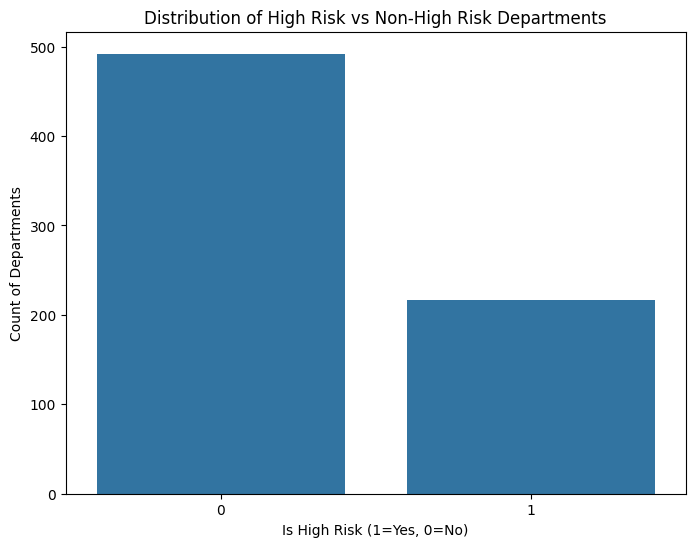

In [17]:
# Visualizing the distribution of high risk vs non-high risk departments
plt.figure(figsize=(8, 6))
sns.countplot(x='is_high_risk', data=departments_full)
plt.title('Distribution of High Risk vs Non-High Risk Departments')
plt.xlabel('Is High Risk (1=Yes, 0=No)')
plt.ylabel('Count of Departments')

# Save plot to visuals folder
plt.savefig(images_path + 'high_risk_department_distribution.png')


### Handling Missing Values

In [23]:
missing_summary = departments_full.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


digital_systems                    304
violations_past_3years             303
oversight_body                     303
interdept_collaboration_score      303
external_interactions_frequency    303
onboarding_program                 302
training_hours_quarterly           300
external_partnerships              300
overall_risk_score                 300
supervisor_experience_level        300
team_size                          300
engagement_programs                299
resource_availability_score        299
risk_exposure_financial            299
location_type                      299
dept_age_years                     298
operational_health_index           298
remediation_plan_active            298
reporting_lag_days                 297
reporting_gaps_annual              297
creation_reason                    297
dept_type                          296
manager_experience_level           296
reporting_structure                296
executive_support                  296
external_consulting      

In [26]:
missing_percent = (departments_full.isnull().mean() * 100).sort_values(ascending=False)
missing_percent[missing_percent > 0]


digital_systems                    42.877292
violations_past_3years             42.736248
oversight_body                     42.736248
interdept_collaboration_score      42.736248
external_interactions_frequency    42.736248
onboarding_program                 42.595205
training_hours_quarterly           42.313117
external_partnerships              42.313117
overall_risk_score                 42.313117
supervisor_experience_level        42.313117
team_size                          42.313117
engagement_programs                42.172073
resource_availability_score        42.172073
risk_exposure_financial            42.172073
location_type                      42.172073
dept_age_years                     42.031030
operational_health_index           42.031030
remediation_plan_active            42.031030
reporting_lag_days                 41.889986
reporting_gaps_annual              41.889986
creation_reason                    41.889986
dept_type                          41.748942
manager_ex

##### Overall we have many missing values accross different columns of approximately 35% to 43%. 

C:\Users\Cesar Dushimimana\AppData\Local\Temp\ipykernel_25604\3624621091.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')


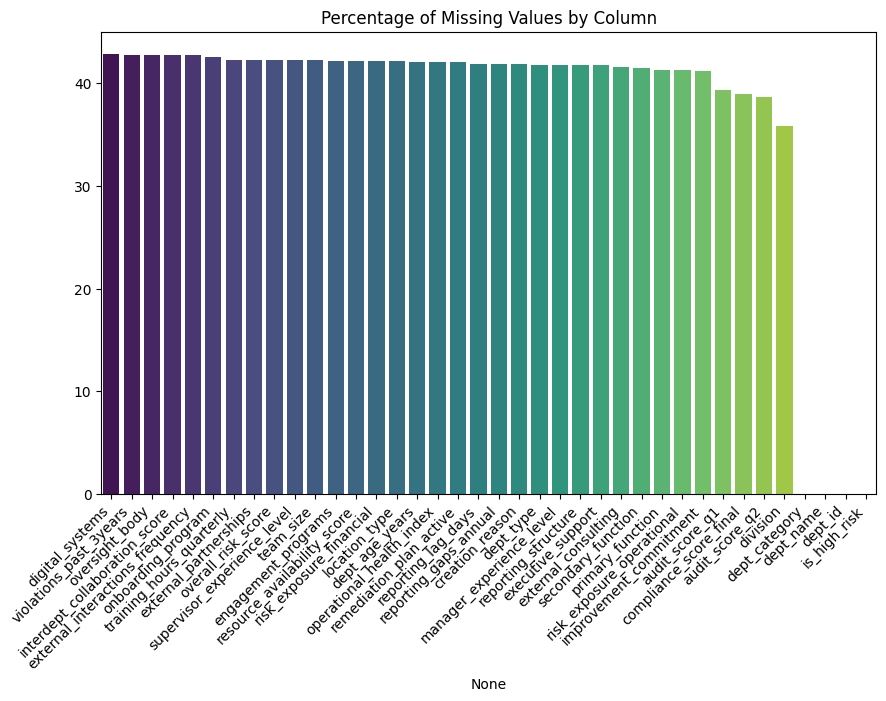

In [27]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')

# Save Visuals to images folder
plt.savefig(images_path + 'missing_values_percentage.png')


#### Identifying Numerical and Categorical Columns

In [37]:
numerical_cols = departments_full.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = departments_full.select_dtypes(include=['object', 'category']).columns.tolist()


### Imputing Missing Values

#### A. Imputing Numeric Values

In [39]:
# Imputing numeric values 

num_imputer = SimpleImputer(strategy='median')
departments_full[numerical_cols] = num_imputer.fit_transform(departments_full[numerical_cols])


#### B. Imputing Categorical Values

In [40]:
# Imputing categorical values by filling with 'Unknown'

departments_full[categorical_cols] = departments_full[categorical_cols].fillna("Unknown")


In [47]:
# Checking that there are no more missing values

missing_summary = departments_full.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


Series([], dtype: int64)

In [48]:
departments_full.head()

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score,is_high_risk
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,3.0,1.0,2.0,5.0,2.0,55.0,55.0,65.0,12.0,0.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,3.0,2.0,2.0,1.0,26.0,60.0,40.0,65.0,43.0,1.0
2,DEPT-4917,Central Hub,Operational_Compliance,Unknown,Unknown,7.0,Unknown,Unknown,Unknown,3.0,...,3.0,1.0,2.0,4.0,2.0,60.0,60.0,65.0,20.0,0.0
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0,0.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0,1.0


### Converting is_high_risk to Categorical

In [63]:
# converting is_high_risk to categorical

departments_full['is_high_risk'] = departments_full['is_high_risk'].map({0: "Not_High_Risk", 1: "High_Risk"}).astype('category')



#### Saving CSV of Cleaned 'departments_full' Dataset

In [66]:
# Saving CSV of Cleaned 'departments_full' Dataset
departments_full.to_csv(processed_data_path + 'departments_full_cleaned.csv', index=False)

### Distribution Visualization & Handling Outliers 

##### A. Distributions of numerical columns, using subplots

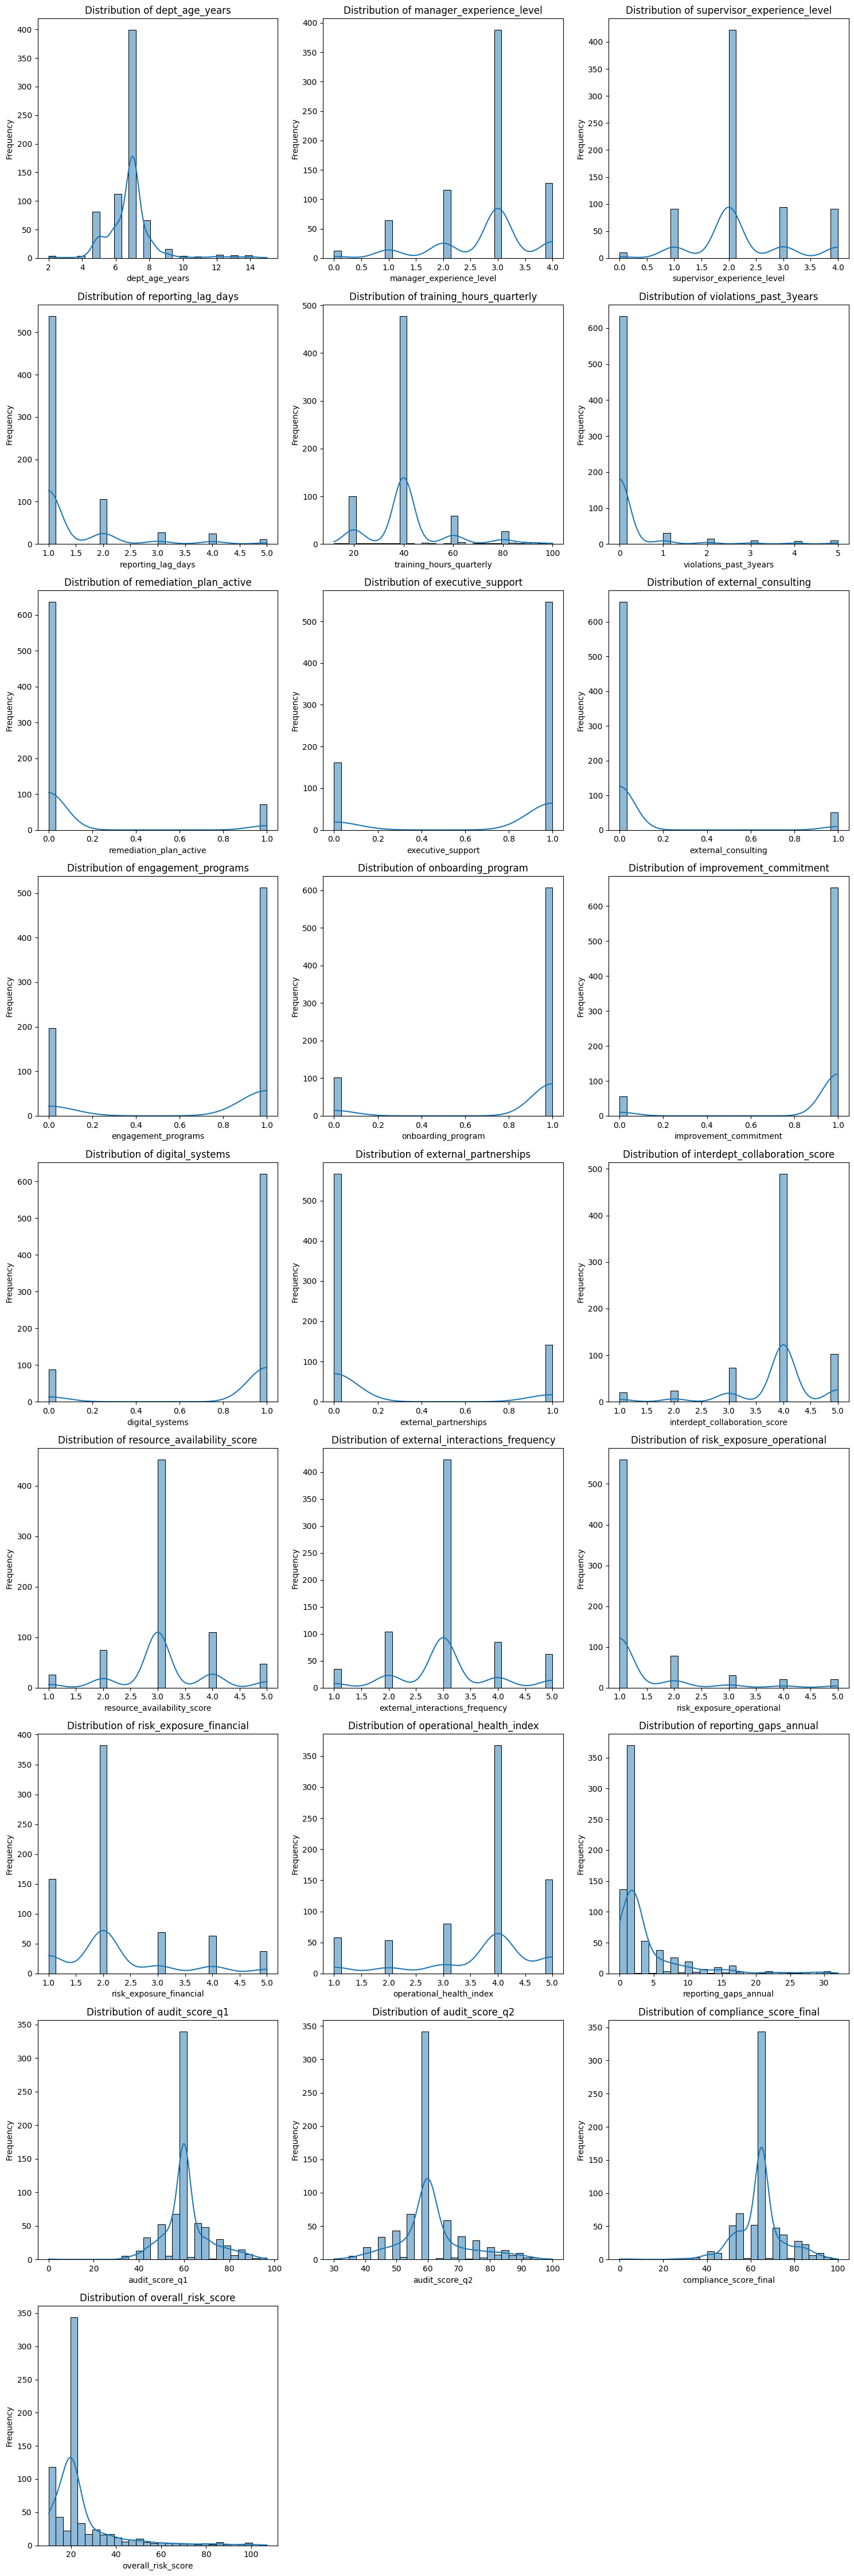

In [67]:
# Distributions of numerical columns, using subplots

num_plots = len(numerical_cols)
cols = 3
rows = (num_plots // cols) + int(num_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

for i, col in enumerate(numerical_cols):
    sns.histplot(departments_full[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

# Save plot to images folder
plt.savefig(images_path + 'numerical_columns_distributions.png')

